In [9]:
import numpy as np
import os
import re
import subprocess
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.cosmology import FlatLambdaCDM 
from astropy.table import Table
import astropy.units as u

from synphot import SpectralElement
from synphot.models import Empirical1D

In [2]:
#Find the redshift of each object. 
z = dict()
d20 = open("../SED_models/double.20")
d22 = open("../SED_models/double.22")
for line in d20:
    x = line.split()
    y = d22.readline().split()
    z[y[-1]] = float(x[1])
d20.close()
d22.close()

In [3]:
#Load the bands with synphot. 
filt_files = {
    "R_SPECIAL":"M_SPECIAL_R.txt",
    "I_BESS": "M_BESS_I.txt",
    "v_HIGH": "v_HIGH.txt"
}
bp = dict()
for key in filt_files:
    skiprows=0
    if key=="v_HIGH":
        skiprows=2
    data = np.loadtxt("../../Filter_Curves/{}".format(filt_files[key]),skiprows=skiprows)
    wave = data[:,0]*10
    thru = data[:,1]
    bp[key] = SpectralElement(Empirical1D, points=wave[wave<10000.], lookup_table=thru[wave<10000.], keep_neg=True)
    print(key, bp[key].barlam(), bp[key].fwhm(), bp[key].rectwidth())

R_SPECIAL 6501.229535920617 Angstrom 1159.881393925198 Angstrom 1624.9974574790472 Angstrom
I_BESS 7908.260159757317 Angstrom 1335.7995225325858 Angstrom 1434.877194229439 Angstrom
v_HIGH 5531.766519253978 Angstrom 849.8588260783428 Angstrom 1195.1036753366664 Angstrom


In [4]:
objects = {"W0019-1046","W0204-0506","W0220+0137","W0831+0140","W0116-0505"}
filters = dict()
for obj in objects:
    filters[obj] = ["R_SPECIAL"]
filters["W0116-0505"].extend(["I_BESS","v_HIGH"])

In [5]:
#Read the polarization fraction values. 
pfrac = dict()
epfrac = dict()
for obj in objects:
    pfrac[obj] = dict()
    epfrac[obj] = dict()
    for filt in filters[obj]:
        data = np.genfromtxt("../../analysis_v3/{}_pol_{}.dat".format(obj,filt), usecols=[0,1,7], dtype=[('pfrac', '<f8'), ('epfrac','<f8'),('OBID','<U10')])
        if len(data.shape)>0:
            k = np.argwhere(data['OBID']=="All")[0][0]
            pfrac[obj][filt] = data['pfrac'][k]
            epfrac[obj][filt] = data['epfrac'][k]
        else:
            pfrac[obj][filt] = data['pfrac']
            epfrac[obj][filt] = data['epfrac']


In [14]:
#Figure out all the SKIRTOR model families. 
skt_folder = "../../Calculations/SKIRTOR"
ls_output = subprocess.run("ls {}/b*.dat".format(skt_folder), shell=True, capture_output=True)
fnames = ls_output.stdout.decode('utf8').split()
angles = dict()
for fname in fnames:
    m = re.search("blueHotDogsPol_(.*?)_i(.*?)_sed.dat", fname)
    if not m:
        m = re.search("bHDPol_(.*?)_i(.*?)_sed.dat", fname)
    mname = m.group(1)
    if mname not in angles:
        angles[mname] = list()
    angles[mname].append(m.group(2))
model_families = list(angles.keys())

In [16]:
#Read the SKIRTOT models for each family. 
skt = dict()
for mf in model_families:
    skt[mf] = dict()
    for ang in angles[mf]:

        #Read the table.
        fname = '../../Calculations/SKIRTOR/blueHotDogsPol_{}_i{}_sed.dat'.format(mf, ang)
        if not os.path.exists(fname):
            fname =  '../../Calculations/SKIRTOR/bHDPol_{}_i{}_sed.dat'.format(mf, ang)

        skt[mf][ang] = Table.read(fname, format='ascii')

        #Rename the columns
        header = ["wavelength", "flux", "Q", "U", "V"]
        for i, col in enumerate(skt[mf][ang].colnames):
            skt[mf][ang].rename_column(col, header[i])

        #Calculate the polarization fraction. 
        skt[mf][ang]["P"] = -skt[mf][ang]["Q"]/skt[mf][ang]["flux"] * 100

        #Put the wavelengths in angstroms. 
        skt[mf][ang]["wavelength"] *= 1e4

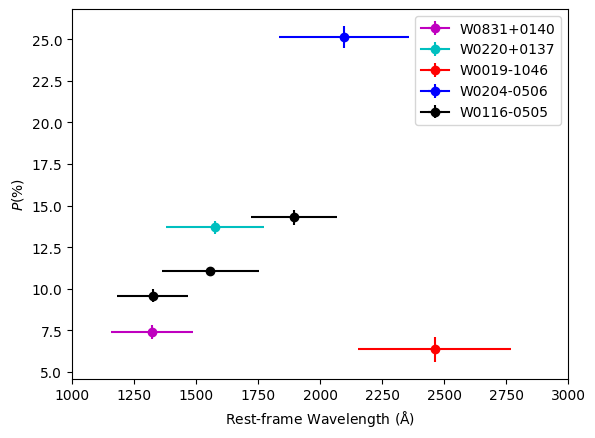

In [17]:
fig, ax = plt.subplots(1)

color = {"W0116-0505":'k', "W0019-1046":"r", "W0204-0506":"b", "W0220+0137":"c", "W0831+0140":"m"}

for obj in objects:
    for j, filt in enumerate(filters[obj]):
        label=None
        if j==0:
            label=obj
        ax.errorbar([bp[filt].barlam().value/(1+z[obj])], [pfrac[obj][filt]], yerr=[epfrac[obj][filt]], xerr=[0.5*bp[filt].rectwidth().value/(1+z[obj])], marker='o', c=color[obj], label=label)
ax.set_xlim([1000,3000])
ax.legend()
ax.set_ylabel(r"$P (\%)$")
ax.set_xlabel(r"Rest-frame Wavelength $(\rm \AA)$")
plt.show()

fig.savefig("pfrac_wavelength.png", dpi=200)

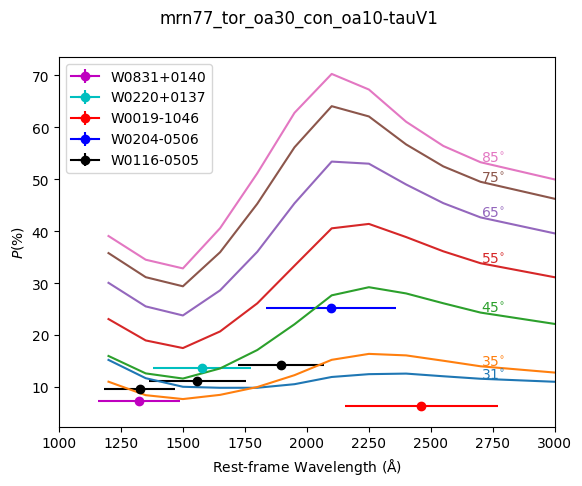

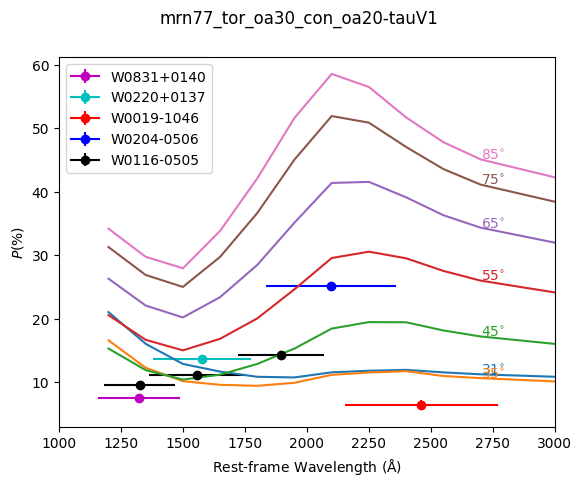

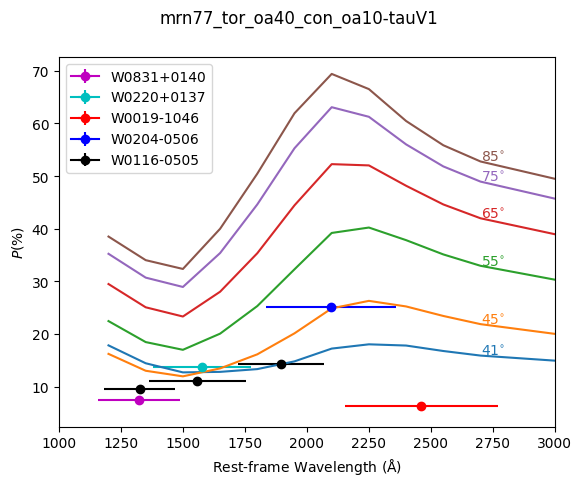

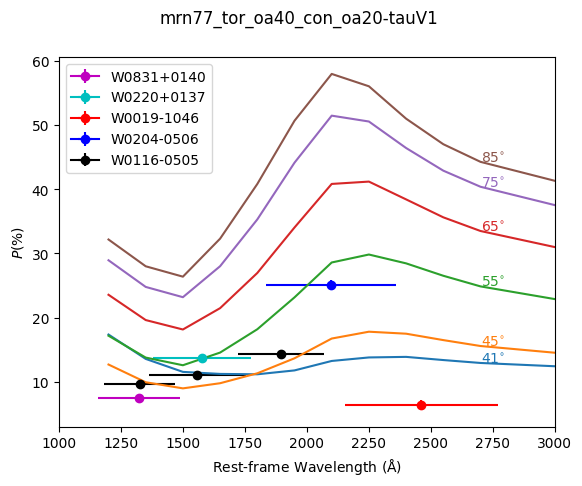

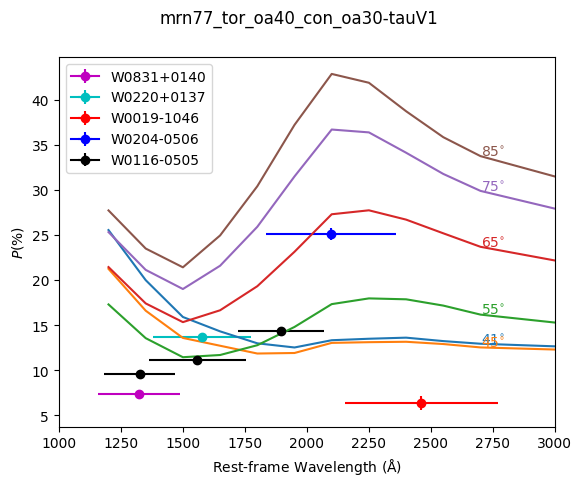

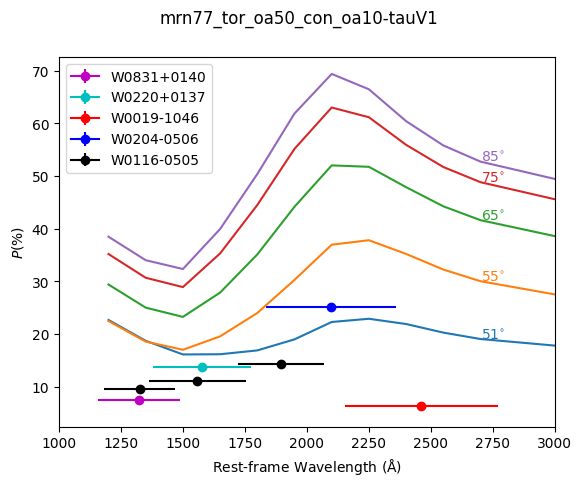

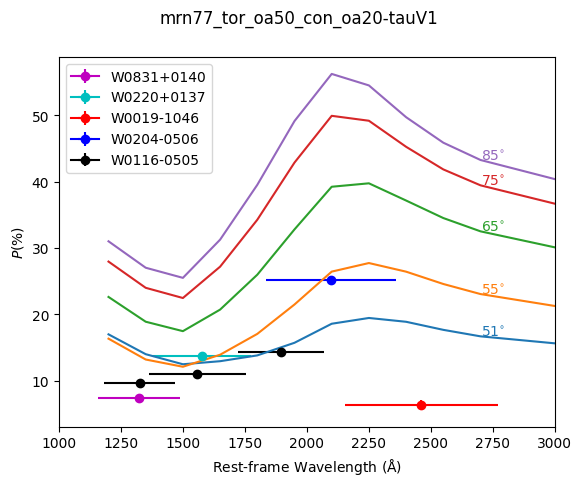

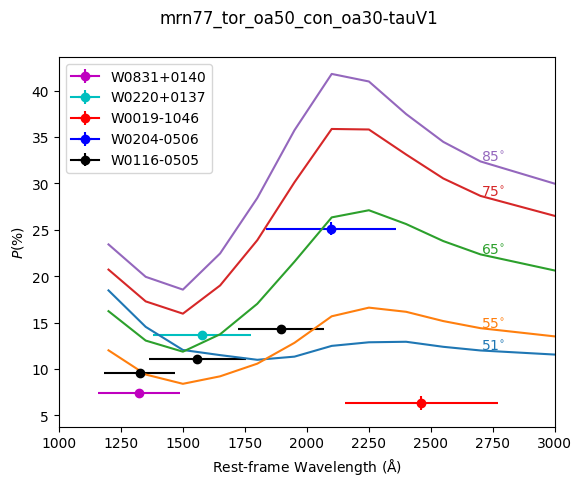

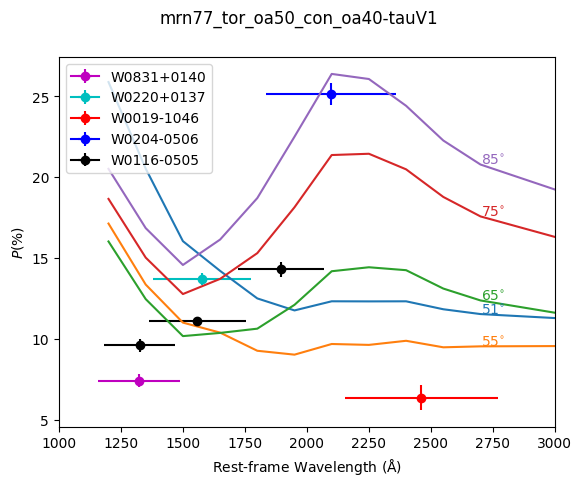

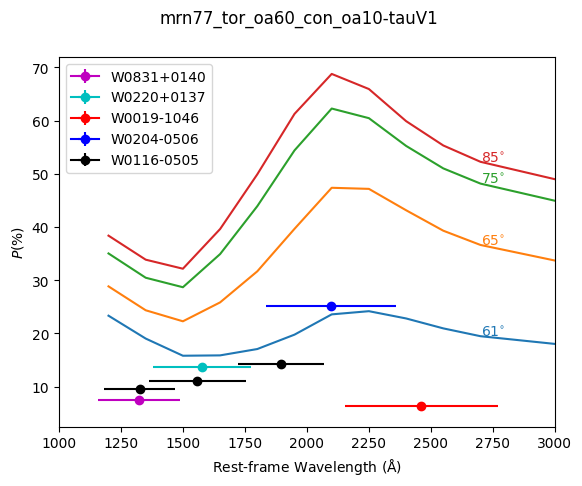

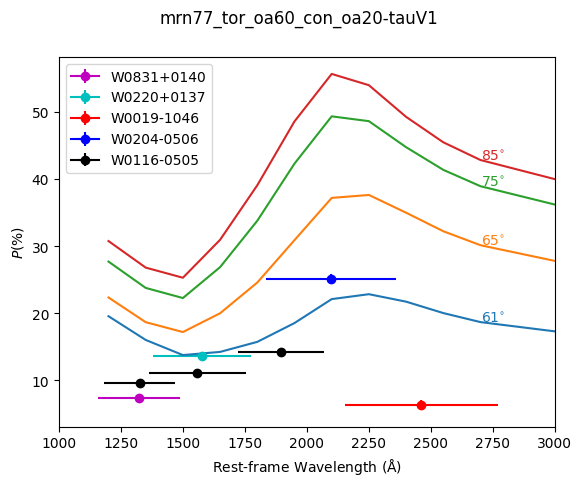

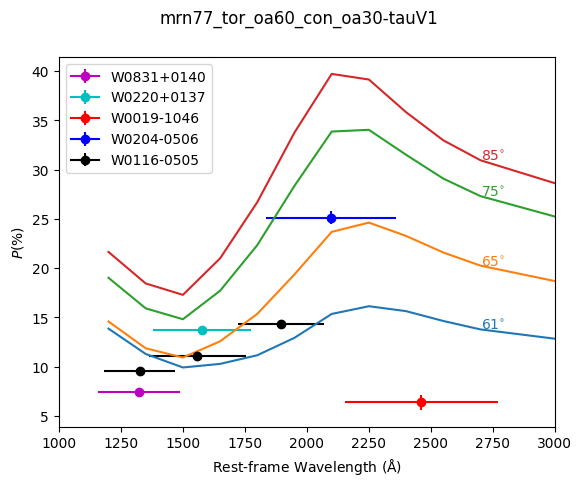

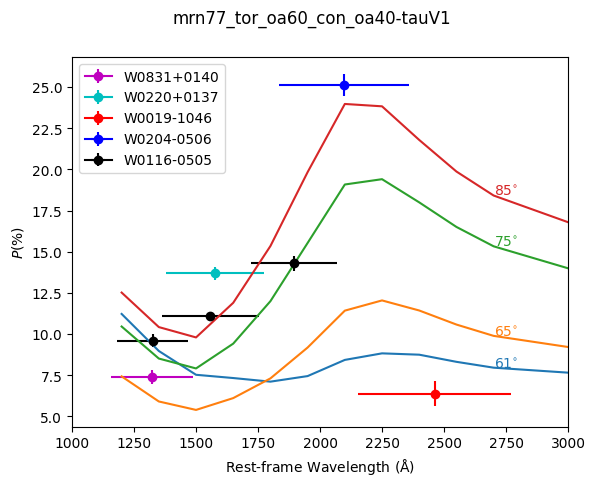

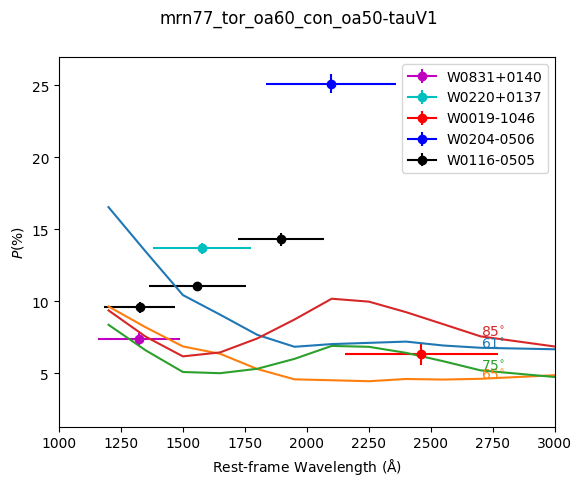

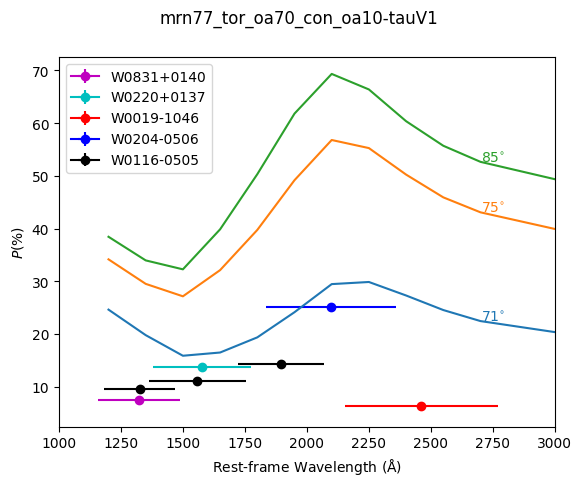

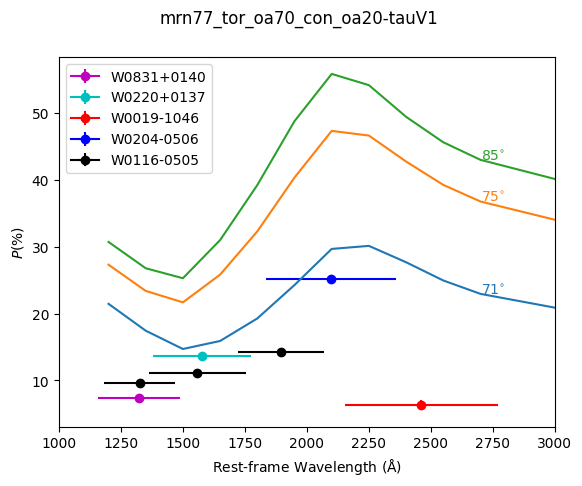

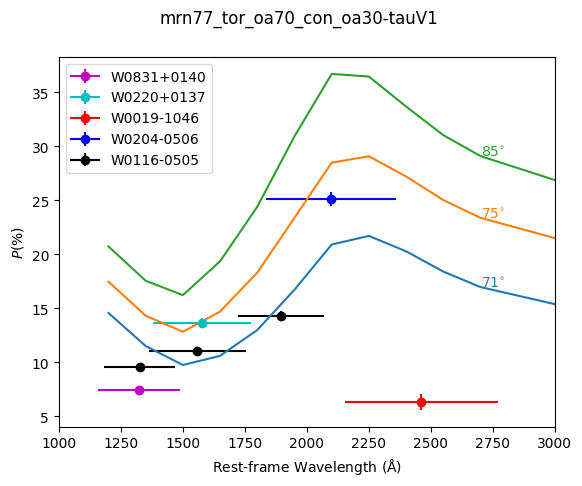

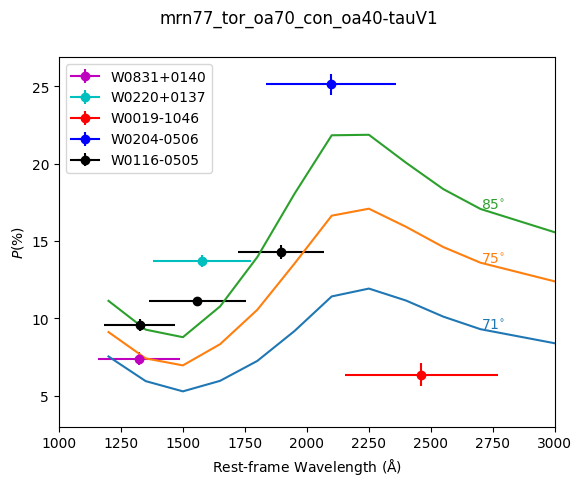

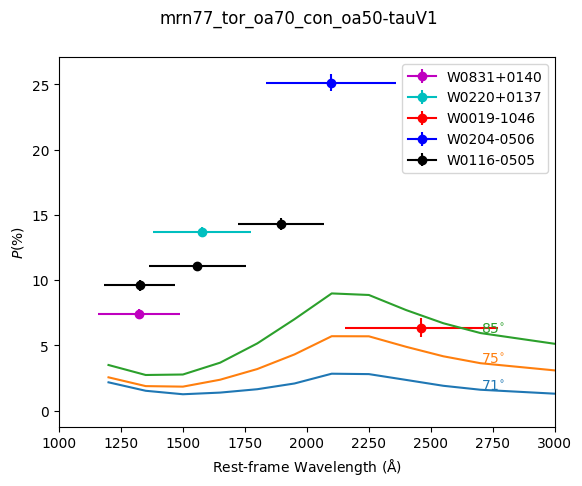

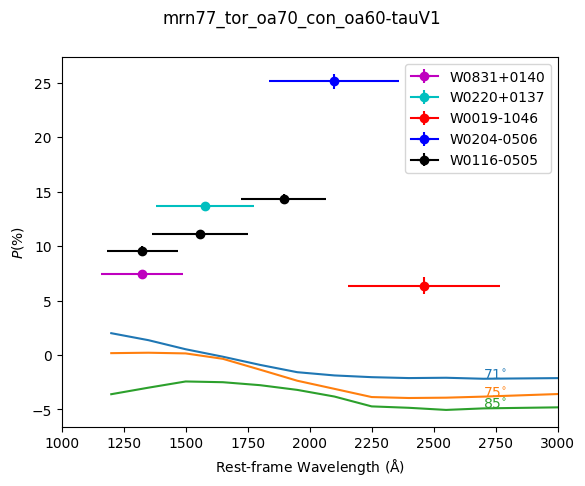

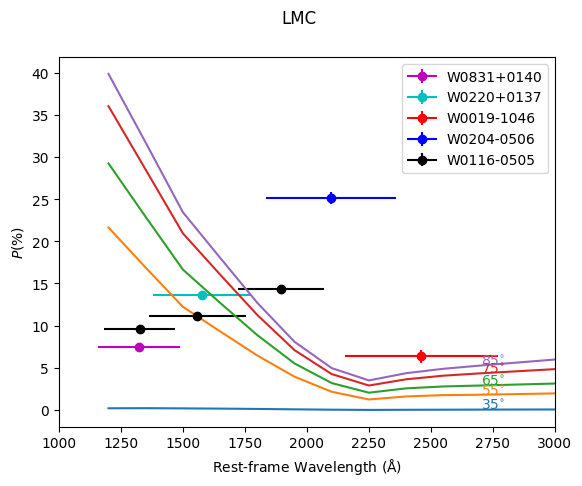

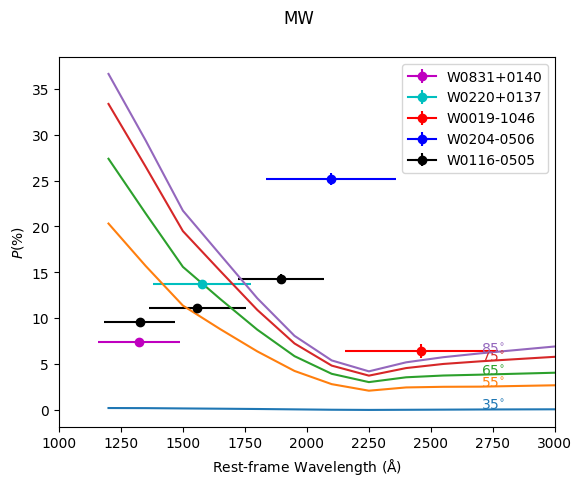

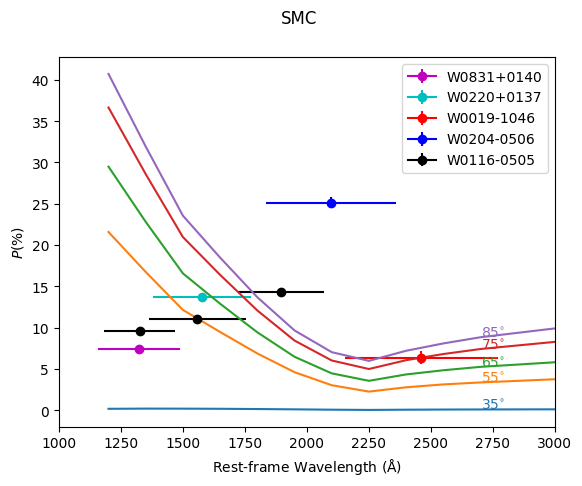

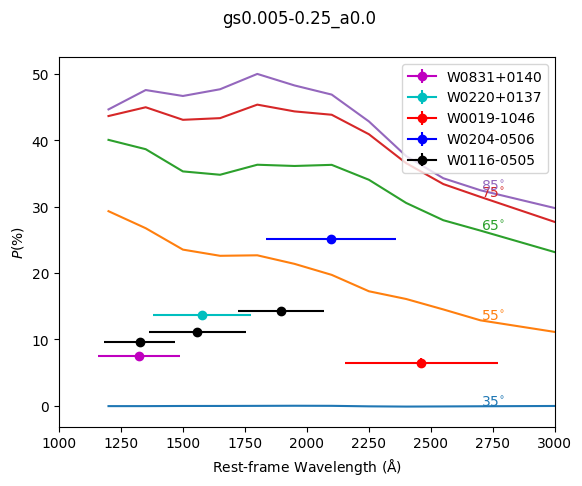

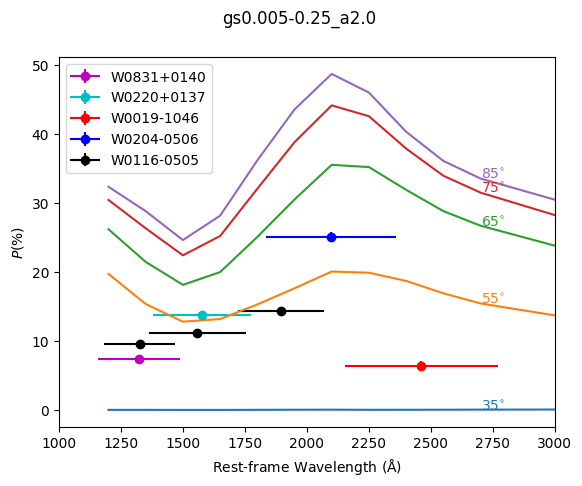

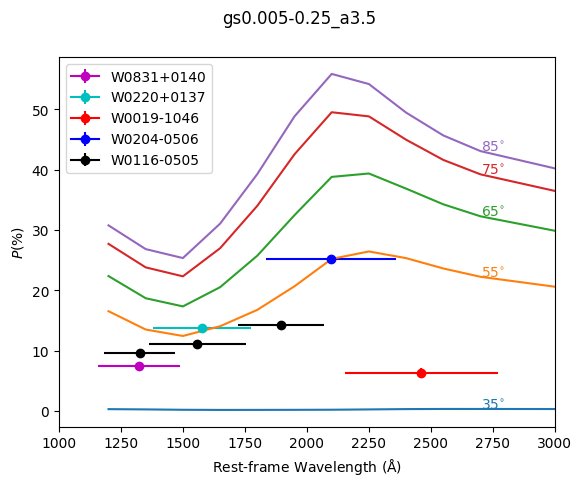

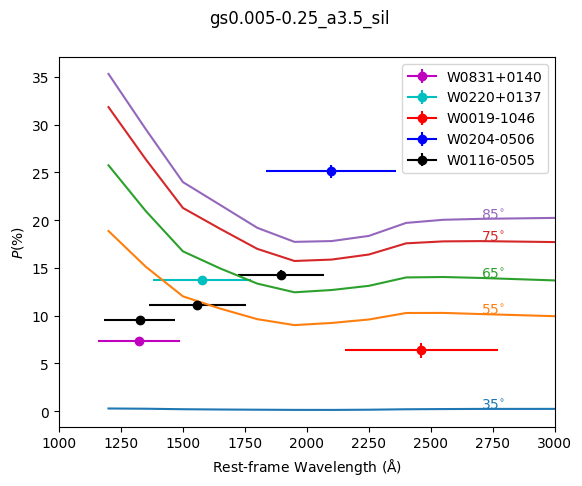

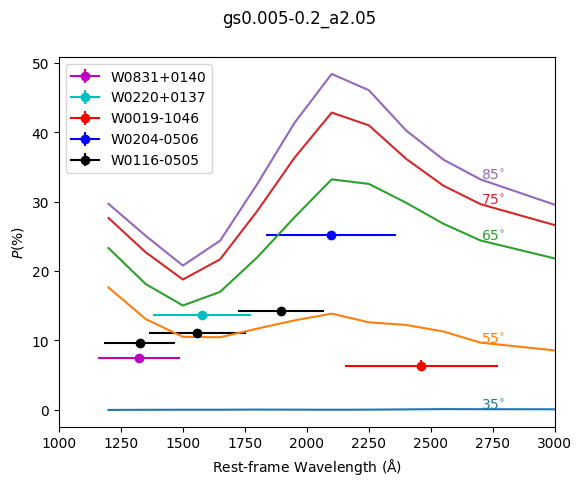

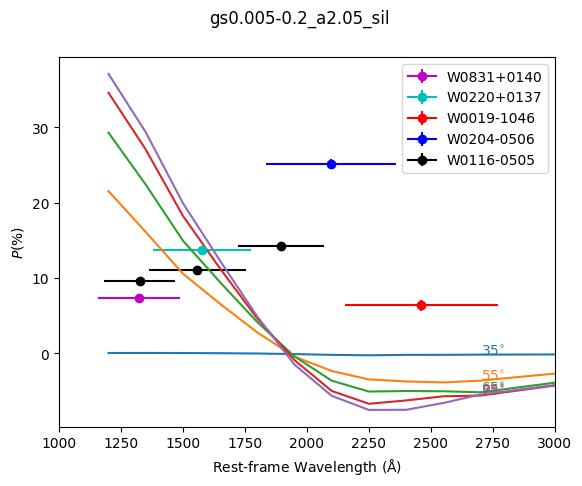

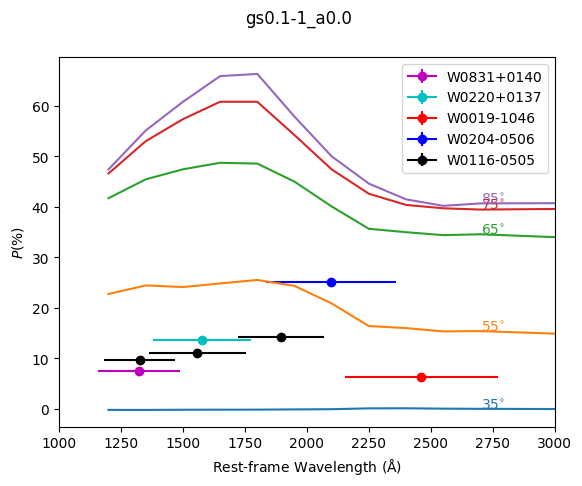

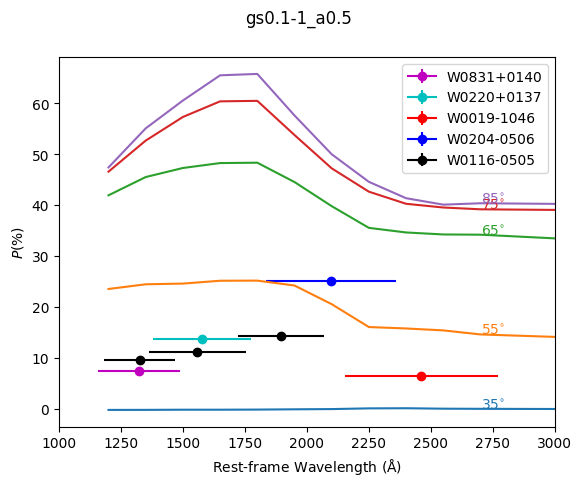

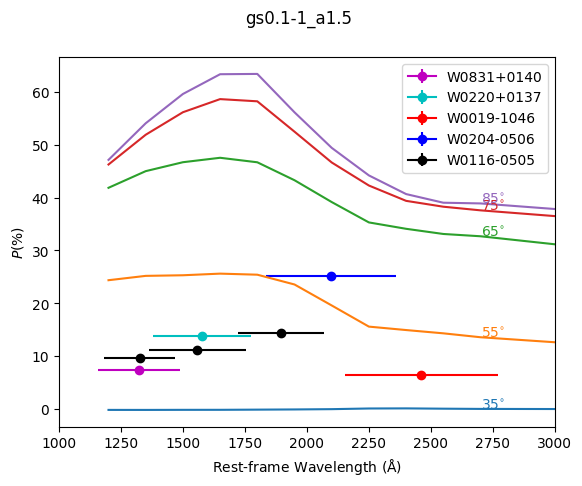

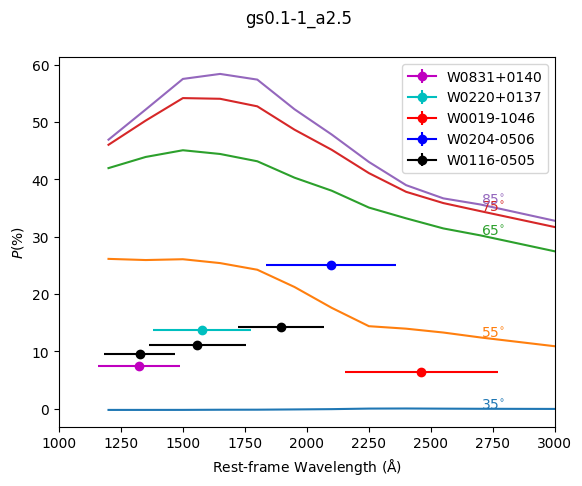

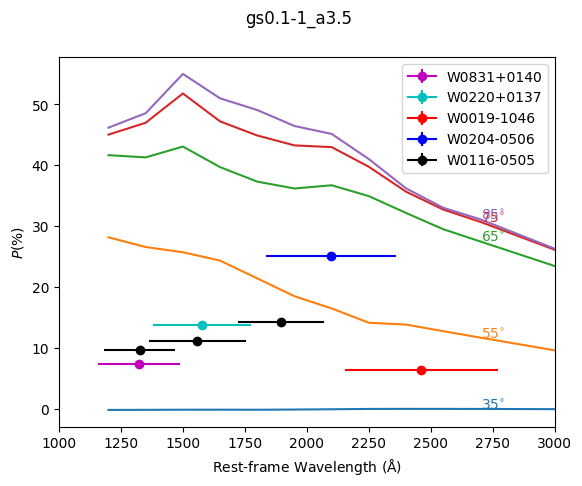

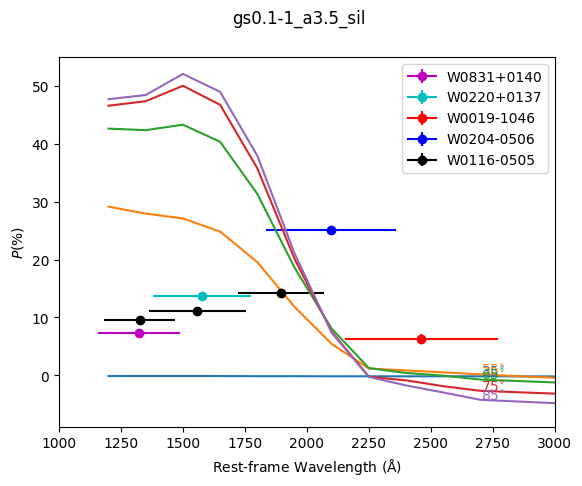

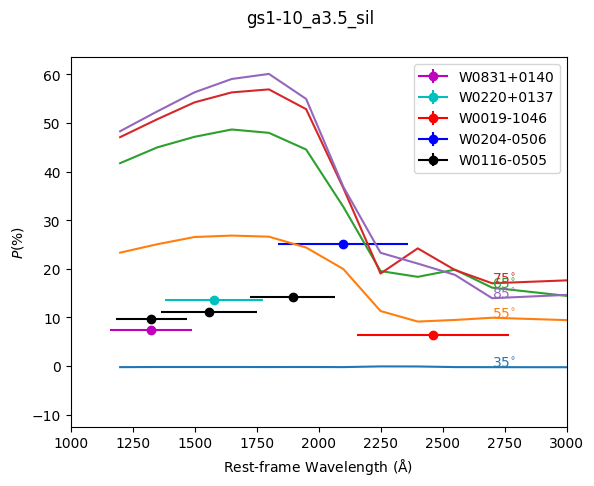

In [18]:
for mf in model_families:
    fig, ax = plt.subplots(1)

    color = {"W0116-0505":'k', "W0019-1046":"r", "W0204-0506":"b", "W0220+0137":"c", "W0831+0140":"m"}

    for obj in objects:
        for j, filt in enumerate(filters[obj]):
            label=None
            if j==0:
                label=obj
            ax.errorbar([bp[filt].barlam().value/(1+z[obj])], [pfrac[obj][filt]], yerr=[epfrac[obj][filt]], xerr=[0.5*bp[filt].rectwidth().value/(1+z[obj])], marker='o', c=color[obj], label=label)

    for ang in skt[mf]:
        aux = ax.plot(skt[mf][ang]["wavelength"], skt[mf][ang]["P"])
        k = np.argmin(np.abs(skt[mf][ang]["wavelength"]-2750))
        ax.text(skt[mf][ang]['wavelength'][k], skt[mf][ang]["P"][k], r'${}^{{\circ}}$'.format(ang), color=aux[0]._color)

    ax.set_xlim([1000,3000])
    ax.legend()
    ax.set_ylabel(r"$P (\%)$")
    ax.set_xlabel(r"Rest-frame Wavelength $(\rm \AA)$")
    fig.suptitle(mf)
    plt.show()

    fig.savefig("skt_pfrac_wavelength.{}.png".format(mf), dpi=200)

In [ ]:
#Summary for Marko.
for obj in objects:
    for filt in filters[obj]:
        print("{:12s} {:10s} {:5.3f} {:6.2f} {:6.2f} {:.0f} {:.0f}".format(obj, filt, z[obj], pfrac[obj][filt], epfrac[obj][filt], bp[filt].barlam().value/(1+z[obj]), bp[key].rectwidth().value/(1+z[obj])))